In [25]:
import sys
!{sys.executable} -m pip install -v "opencv-python==4.5.1.48"
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn


Using pip 21.1.2 from d:\projects\put\computer-vision-project-2\venv\lib\site-packages\pip (python 3.7)
Non-user install because user site-packages disabled
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-ephem-wheel-cache-8n_5d8b4
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-on1k0dse
Initialized build tracking at C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-on1k0dse
Created build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-on1k0dse
Entered build tracker: C:\Users\aszcz\AppData\Local\Temp\pip-req-tracker-on1k0dse
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-install-bn5n8bl7
Created temporary directory: C:\Users\aszcz\AppData\Local\Temp\pip-unpack-hb5l3g3t
Removed build tracker: 'C:\\Users\\aszcz\\AppData\\Local\\Temp\\pip-req-tracker-on1k0dse'


Wczytywanie obrazu indeksu

In [26]:
import math
import numpy as np
import cv2
from cv2 import imread, threshold, THRESH_BINARY_INV, imshow, waitKey
from matplotlib import pyplot as plt

img = imread("dupa-small.png", cv2.IMREAD_GRAYSCALE)
ret, bw = threshold(img, 127, 255, THRESH_BINARY_INV)

im_height, im_width = bw.shape

Dzielenie indeksu na osobne obrazy-cyfry oraz przycinanie boków tych obrazów

In [27]:
digits = []
col = 0
while col < im_width:
    if not all(px == 0 for px in bw[:, col]):

        start_index = col
        while col < im_width and not all(px == 0 for px in bw[:, col]):
            col += 1

        end_index = col - 1

        digits.append(bw[0:im_height, start_index:end_index])
    col += 1

Przycinanie obrazów cyfr z góry i z dołu

In [28]:
for i in range(len(digits)):
    d = digits[i]

    row = 0
    while all(px == 0 for px in d[row]):
        row += 1
    start_index = row

    row = d.shape[0] - 1
    while all(px == 0 for px in d[row]):
        row -= 1
    end_index = row + 1

    digits[i] = d[start_index:end_index, 0:d.shape[0]]

Upodobnienie obrazów cyfr do obrazów z klasyfikatora mnist (skalowanie oraz dodanie czarnego obramowania)

In [29]:
from cv2 import resize, INTER_AREA, copyMakeBorder, BORDER_CONSTANT, dilate

for i in range(len(digits)):
    d = digits[i]
    d_height, d_width = d.shape

    d_proportion = d_width / d_height
    sample_size = 28
    border_size = 8
    max_size = sample_size - border_size

    if d_width > d_height:
        d = resize(d, (max_size, int(max_size * d_proportion)), interpolation=INTER_AREA)
    else:
        d = resize(d, (int(max_size * d_proportion), max_size), interpolation=INTER_AREA)

    border_vertical = (sample_size - d.shape[0]) / 2
    border_verticalT = math.ceil((sample_size - d.shape[0]) / 2)
    border_verticalB = math.floor((sample_size - d.shape[0]) / 2)

    border_horizontal = (sample_size - d.shape[1]) / 2
    border_horizontalL = math.ceil(border_horizontal)
    border_horizontalR = math.floor(border_horizontal)

    d = copyMakeBorder(d, border_verticalT, border_verticalB, border_horizontalL, border_horizontalR, BORDER_CONSTANT)

    kernel = np.ones((2, 2), np.uint8)
    d = dilate(d, kernel, iterations=1)

    # print(d.shape)
    digits[i] = d

Uczenie klasyfikatora SVM na zbiorze danych mnist (lub wczytanie go z pliku)

In [30]:
import os
import pickle
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC

dataset_pickle_path = "dataset_mnist.pickle"
clf_pickle_path = "clf_mnist.pickle"

if not os.path.isfile(dataset_pickle_path):
    X, y = data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    with open(dataset_pickle_path, 'wb') as f:
        pickle.dump(data, f)
else:
    with open(dataset_pickle_path, 'rb') as f:
        X, y = pickle.load(f)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

if not os.path.isfile(clf_pickle_path):
    clf = SVC()
    clf.fit(X, y)
    with open(clf_pickle_path, 'wb') as f:
        pickle.dump(clf, f)
else:
    with open(clf_pickle_path, 'rb') as f:
        clf = pickle.load(f)

# y_pred = clf.predict(X_test)
# print(accuracy_score(y_test, y_pred))

Podgląd przetworzonych cyfr oraz cyfr ze zbioru mnist

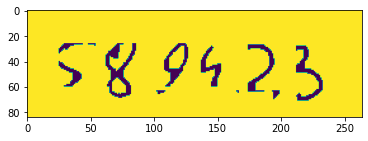

['5']


In [31]:
# for d in [bw] + digits:
#     plt.imshow(d)
#     plt.show()
plt.imshow(bw)
plt.show()

# for i in range(10):
#     plt.imshow(X[i].reshape(28,28))
#     plt.show()  

reshaped = np.array([d.reshape(784) for d in digits])
print(clf.predict(reshaped))